# Loading Libraries

In [99]:
import numpy as np 
import pandas as pd 
pd.options.display.max_columns = None

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

import os, gc
import missingno as msno
from sklearn.model_selection import train_test_split,  KFold

from sklearn.metrics import mean_squared_error
from tqdm import tqdm

In [63]:
df = pd.read_csv("/kaggle/input/cepheus-23-data-science-hackathon-ps-ii/Train.csv")
test = pd.read_csv("/kaggle/input/cepheus-23-data-science-hackathon-ps-ii/Test.csv")

In [64]:
df.isnull().sum()

Unnamed: 0             0
ID                     0
Name                   0
H                      0
Diameter             954
Eccentricity (e)       0
Semi-major axis        0
Inclination            0
om                   954
w                    954
Mean Anomaly           0
Aphelion distance    954
Mean distance          0
tp_r                 954
tp                     0
tp_cal                 0
per                    0
sigma_e                0
sigma_a              954
sigma_q              954
sigma_i                0
sigma_om               0
sigma_w                0
sigma_ma             954
sigma_ad               0
sigma_n                0
sigma_tp               0
sigma_per            954
rms                    0
Hazard_rate            0
dtype: int64

**Insights:**

* The training set contains 955878 samples
* It has 30 features.
* There are 954 missing values in 9 features

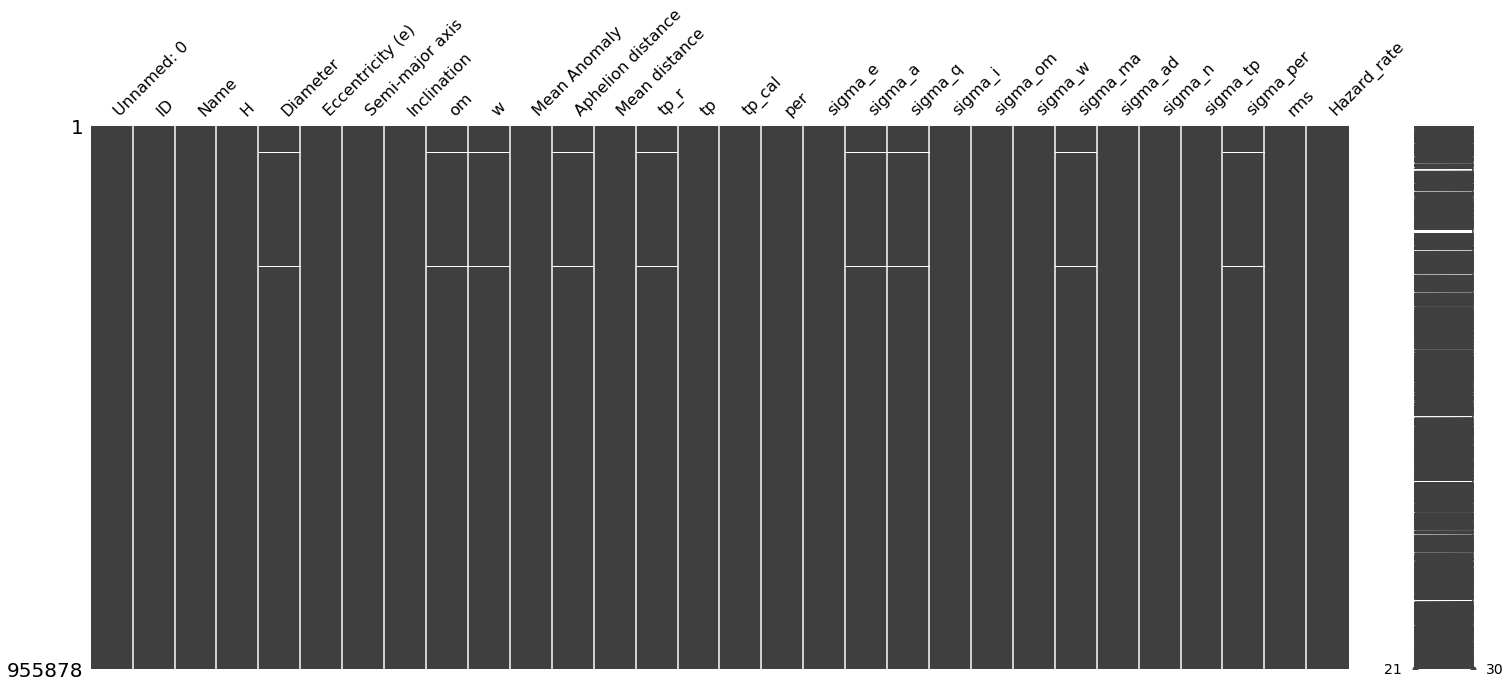

In [65]:
msno.matrix(df)
plt.show()

### From the above diagram its clear that the missing values are all from the same row so it can be dropped

In [66]:
# df[['Diameter','om','w','Aphelion distance','tp_r','sigma_a','sigma_q','sigma_ma','sigma_per']].fillna(df[['Diameter','om','w','Aphelion distance','tp_r','sigma_a','sigma_q','sigma_ma','sigma_per']].mean(), inplace=True)
df.dropna(axis=0,inplace=True,how='any')

In [67]:
df.shape

(954924, 30)

In [68]:
# Removing the unwanted column
df.drop(['ID', 'Name', 'Unnamed: 0'],axis=1, inplace=True)
test.drop(['ID', 'Name', 'Unnamed: 0'],axis=1, inplace=True)

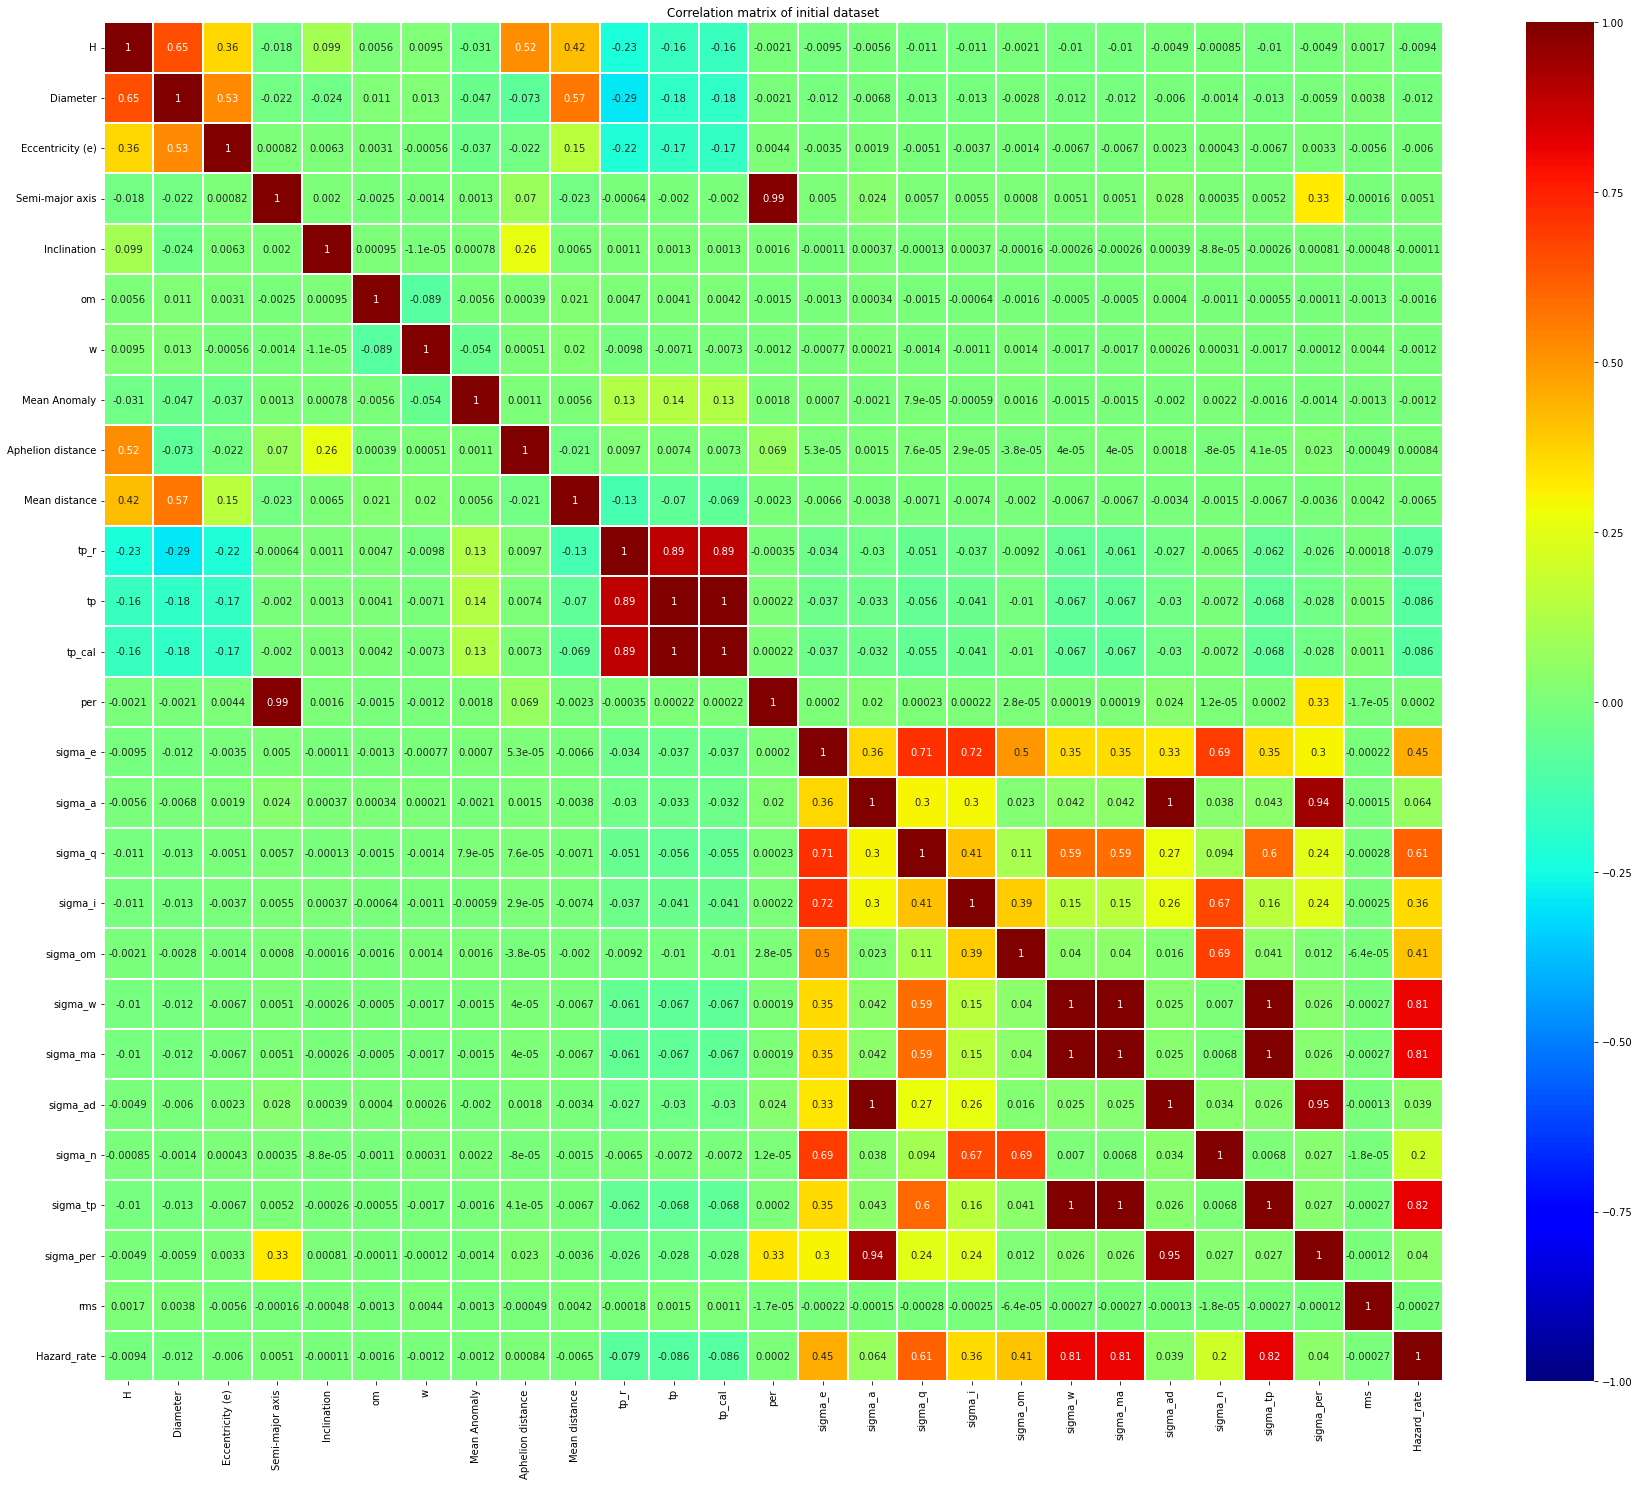

In [69]:
correlation_matrix=df.corr()
plt.figure(figsize=(30,25))
plt.title("Correlation matrix of initial dataset")
sns.heatmap(data=correlation_matrix,cmap='jet',vmin=-1,vmax=1,linewidth=1.5,annot=True)
fig1 = plt.gcf()
plt.show()

In [70]:
highly_cor = df.corr().nlargest(7, "Hazard_rate").index

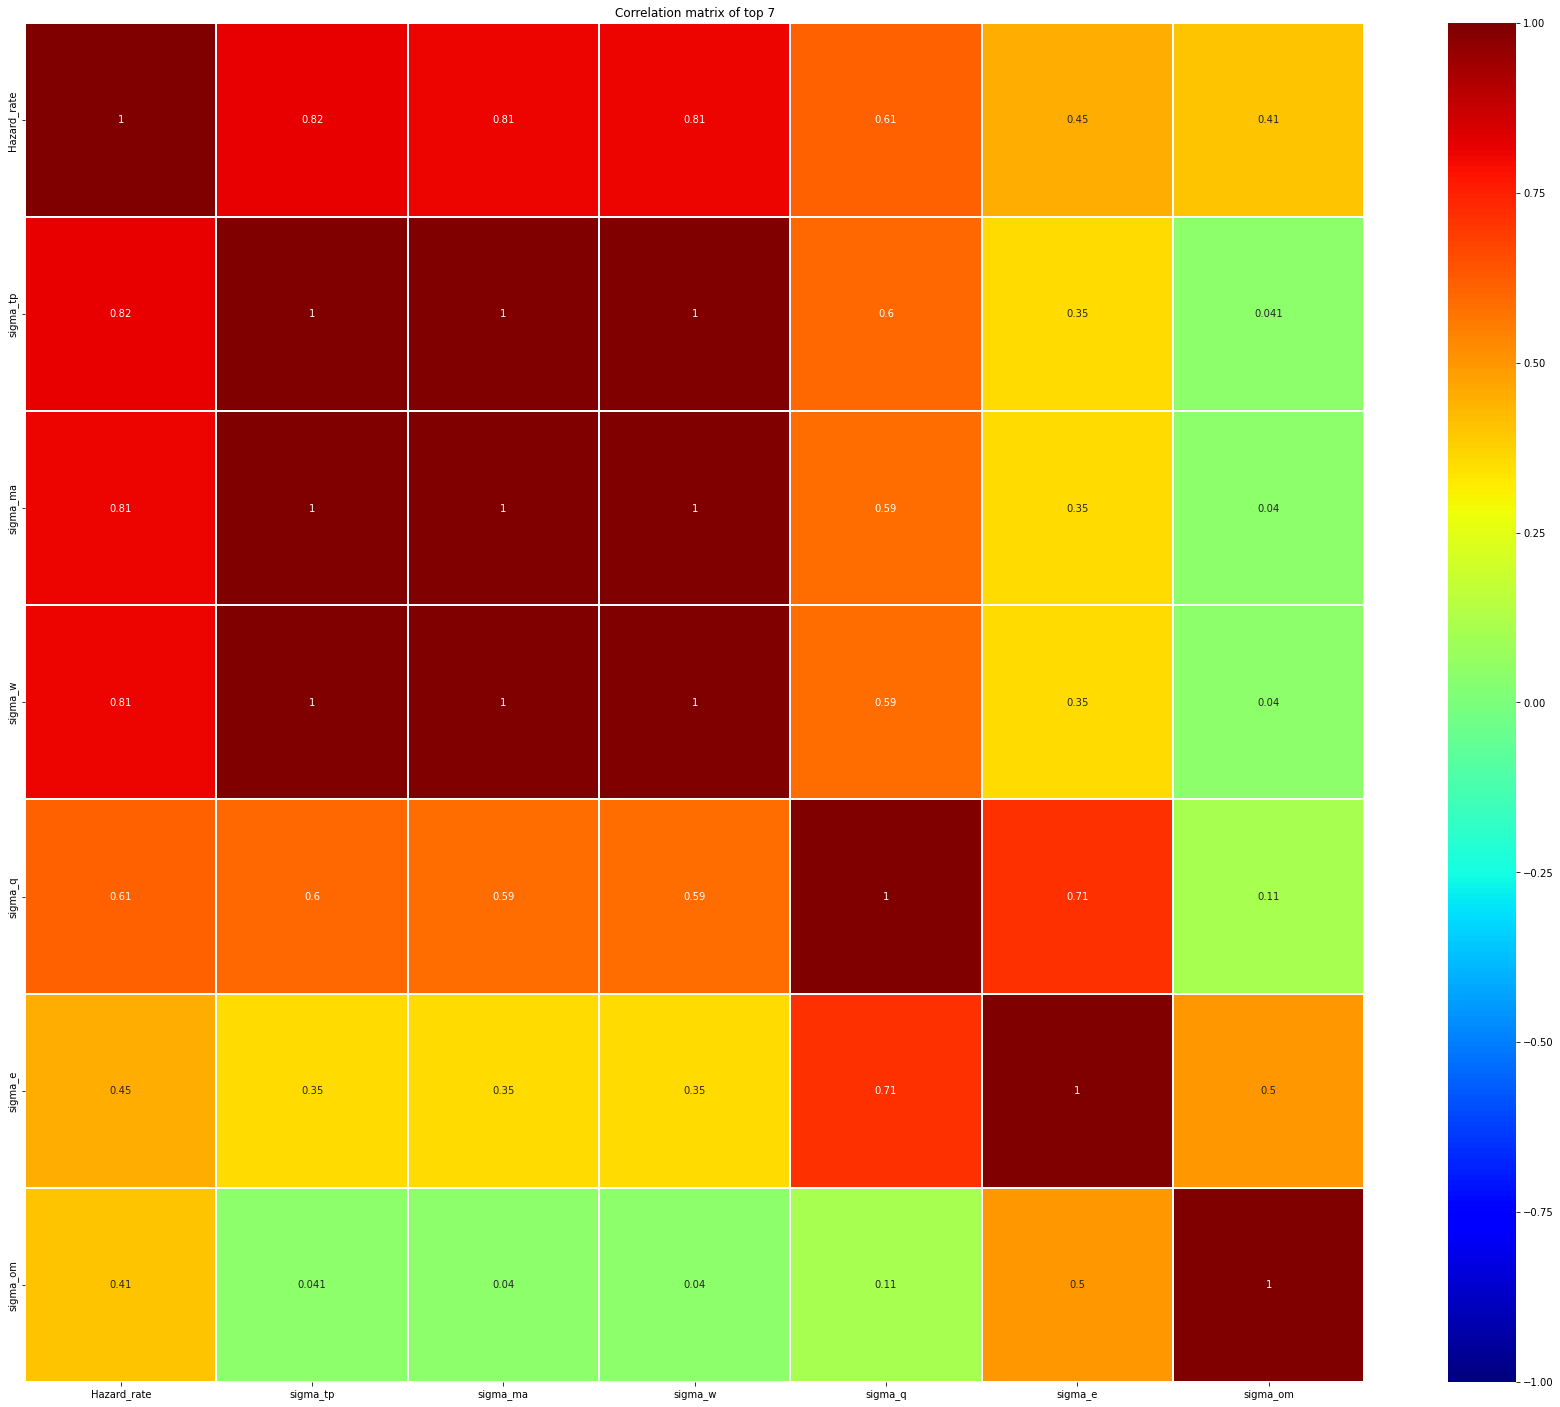

In [71]:
correlation_matrix=df[highly_cor].corr()
plt.figure(figsize=(30,25))
plt.title("Correlation matrix of top 7")
sns.heatmap(data=correlation_matrix,cmap='jet',vmin=-1,vmax=1,linewidth=1.5,annot=True)
fig1 = plt.gcf()
plt.show()

# We can remove sigma_tp and sigma_ma as multicolinearity will make the linear model unstable

In [72]:
df = df[['sigma_e', 'sigma_q', 'sigma_i', 'sigma_om', 
       'sigma_w','Hazard_rate']]

In [73]:
X = df.drop("Hazard_rate", axis=1)
y = df["Hazard_rate"].values

# Standardizing the dataframe

In [74]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
sfit = scaler.fit(X)
X = sfit.transform(X)

In [84]:
depth=[]
score_rmse = []
count=0
kf = KFold(n_splits=20)

temp_acc=[]
for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    regr_1 = sklearn.linear_model.LinearRegression()

    regr_1.fit(X_train, y_train)
    
    score_rmse.append(mean_squared_error(y_test,regr_1.predict(X_test), squared=False))
    temp_acc.append(mean_squared_error(y_test,regr_1.predict(X_test), squared=False))
    print(mean_squared_error(y_test,regr_1.predict(X_test), squared=False))
    count+=1
    if count==4: # choosing 4th split as it gave better result
        break

97.273235307545
99.5220151312932
124.13771424598458
24.905977488456166


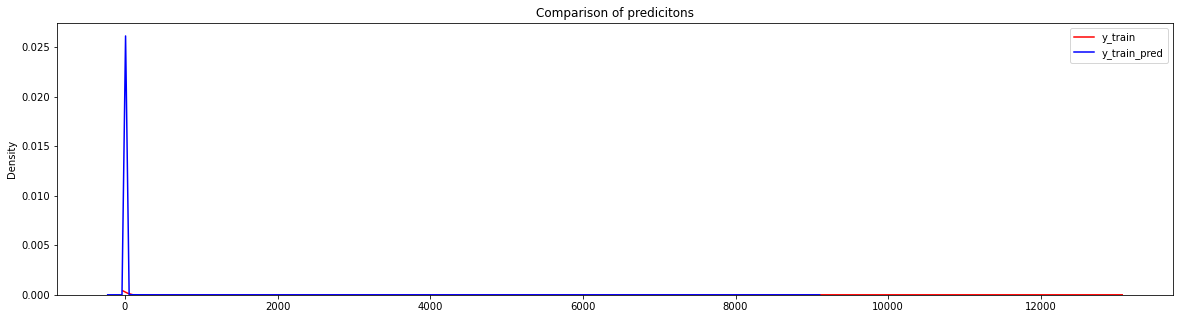

In [98]:
plt.figure(figsize=(20,5))
ax1 = sns.kdeplot(y_test,label = 'y_train',color="red")
ax2 = sns.kdeplot(regr_1.predict(X_test),label = 'y_train_pred',color="blue")

plt.title("Comparison of predicitons")
plt.legend()
plt.show()

In [85]:
test=test[['sigma_e', 'sigma_q', 'sigma_i', 'sigma_om', 
       'sigma_w']]

test = sfit.transform(test)

pred = regr_1.predict(test)
pred

array([0.92717626, 1.31382861, 0.96309024, ..., 0.90605229, 0.907212  ,
       0.90603742])

In [88]:
subm = pd.read_csv("/kaggle/input/cepheus-23-data-science-hackathon-ps-ii/Sample Submission.csv")
subm['Hazard_rate']=pred
subm.to_csv("sudharshan_question2.csv", index=False)